# Stacking Ensemble Machine Learning (Stacked Generalization)
https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/

In [1]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor, plot_importance
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.metrics import r2_score
import pickle

import plotly.express as px

C:\Users\boure\anaconda3\envs\rb_ds\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df = pd.read_csv("../Datas/data.csv")

In [3]:
X_train = df[(df.month <=  8) | (df.year == 2011)].drop(["datetime", "weather","count"], axis=1)
X_test = df[(df.month >  8) & (df.year == 2012)].drop(["datetime", "weather","count"], axis=1)
y_train = np.log1p(df[(df.month <=  8) | (df.year == 2011)]["count"])
y_test = np.log1p(df[(df.month >  8) & (df.year == 2012)]["count"])

In [4]:
df_final_X = df.drop(["datetime", "weather","count"], axis=1)
df_final_y = np.log1p(df["count"])


In [5]:
df_final_X.describe()

,season,holiday,workingday,temp,humidity,windspeed,month,day_number,year,hour
count,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,20.23086,61.886460,12.799395,6.521495,9.992559,2011.501929,11.541613
std,1.116174,0.166599,0.466159,7.79159,19.245033,8.164537,3.444373,5.476608,0.500019,6.915838
min,1.000000,0.000000,0.000000,0.82000,0.000000,0.000000,1.000000,1.000000,2011.000000,0.000000
25%,2.000000,0.000000,0.000000,13.94000,47.000000,7.001500,4.000000,5.000000,2011.000000,6.000000
50%,3.000000,0.000000,1.000000,20.50000,62.000000,12.998000,7.000000,10.000000,2012.000000,12.000000
75%,4.000000,0.000000,1.000000,26.24000,77.000000,16.997900,10.000000,15.000000,2012.000000,18.000000
max,4.000000,1.000000,1.000000,41.00000,100.000000,56.996900,12.000000,19.000000,2012.000000,23.000000


In [6]:
df_final_y.describe()

count    10886.000000
mean         4.591364
std          1.419454
min          0.693147
25%          3.761200
50%          4.983607
75%          5.652489
max          6.885510
Name: count, dtype: float64

In [5]:
one_hot_features = ["holiday", "workingday", "season", "month", "day", "year"]
standard_feature = ["temp", "humidity", "windspeed", "day_number", "hour"]

one_hot_pipeline = make_pipeline(OneHotEncoder(handle_unknown="ignore"))
standard_pipeline = make_pipeline(StandardScaler())

processor = make_column_transformer((one_hot_pipeline, one_hot_features), (standard_pipeline, standard_feature))

In [8]:

# get a list of models to evaluate



In [6]:
rfr = make_pipeline(processor, RandomForestRegressor(random_state=1))
etr = make_pipeline(processor, ExtraTreesRegressor(random_state=1))
lgbm = make_pipeline(processor, LGBMRegressor(random_state=1))
xgbr = make_pipeline(processor, XGBRegressor(random_state=1))

In [7]:
# compare machine learning models for regression
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from matplotlib import pyplot


# get a list of models to evaluate
def get_models():
    models = dict()
    models['rfr'] = make_pipeline(processor, RandomForestRegressor(random_state=1))
    models['etr'] = make_pipeline(processor, ExtraTreesRegressor(random_state=1))
    models['lgbm'] = make_pipeline(processor, LGBMRegressor(random_state=1))
    models['xgbr'] = make_pipeline(processor, XGBRegressor(random_state=1))
    
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X_train, y_train, X_test, y_test):
	
	model.fit(X_train, y_train)
	scores = model.score(X_test, y_test)

	return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model,X_train, y_train, X_test, y_test)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))


>rfr 0.899 (0.000)
>etr 0.934 (0.000)
>lgbm 0.922 (0.000)
>xgbr 0.912 (0.000)


In [8]:
# make a prediction with a stacking ensemble
from sklearn.ensemble import StackingRegressor

# define the base models
level0 = list()

level0.append(('rfr', make_pipeline(processor, RandomForestRegressor(random_state=1))))
level0.append(('etr', make_pipeline(processor, ExtraTreesRegressor(random_state=1))))
level0.append(('lgbm', make_pipeline(processor, LGBMRegressor(random_state=1))))
level0.append(('xgbr', make_pipeline(processor, XGBRegressor(random_state=1))))
# define meta learner model
level1 = LinearRegression()
# define the stacking ensemble
model = StackingRegressor(estimators=level0, final_estimator=level1)
# fit the model on all available data
model.fit(X_train, y_train)
# make a prediction for one example

y_pred = model.predict(X_test)
# print('Predicted Value: %.3f' % (y_pred))

In [12]:
model.score(X_test,y_test)

0.9296491546064493

In [13]:
model.stack_method

'predict'

In [14]:
tmp = {'y_test': y_test, 'y_pred':y_pred}
result = pd.DataFrame(data=tmp , columns=['y_test','y_pred'])
result['diff'] = result['y_test'] - result['y_pred'] 

In [15]:
X_test

,season,holiday,workingday,temp,humidity,windspeed,day,month,day_number,year,hour
9063,3,0,0,30.34,62,7.0015,Saturday,9,1,2012,0
9064,3,0,0,29.52,74,8.9981,Saturday,9,1,2012,1
9065,3,0,0,28.70,70,11.0014,Saturday,9,1,2012,2
9066,3,0,0,28.70,70,7.0015,Saturday,9,1,2012,3
9067,3,0,0,28.70,70,0.0000,Saturday,9,1,2012,4
...,...,...,...,...,...,...,...,...,...,...,...
10881,4,0,1,15.58,50,26.0027,Wednesday,12,19,2012,19
10882,4,0,1,14.76,57,15.0013,Wednesday,12,19,2012,20
10883,4,0,1,13.94,61,15.0013,Wednesday,12,19,2012,21
10884,4,0,1,13.94,61,6.0032,Wednesday,12,19,2012,22


In [16]:


X_test_res = X_test
X_test_res["diff"] = result['y_test'] - result['y_pred'] 

px.scatter(X_test_res,y='diff',hover_data=["hour","humidity","temp","windspeed"])
#fig.update_traces(mode="markers")
# fig.show()

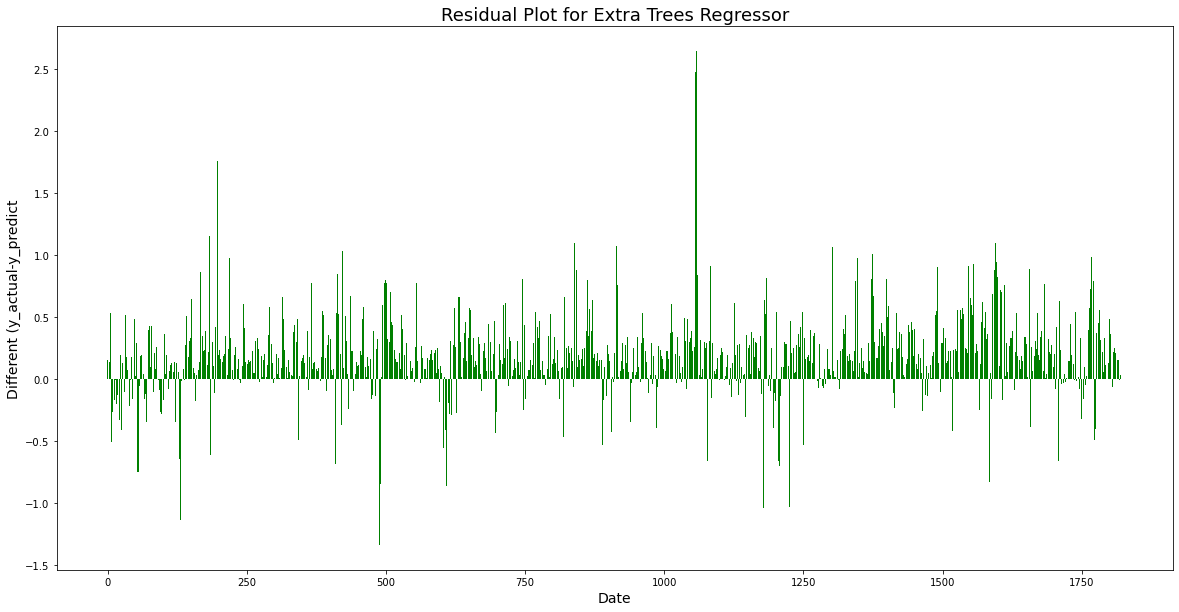

In [17]:
plt.rcParams["figure.figsize"] = (20,10)

fig, ax = plt.subplots()
plt.title('Residual Plot for Extra Trees Regressor',fontsize=18)
x_axis = list(range(0, len(result)))
ax.bar(x_axis, result['diff'],color='green')
ax.set_xlabel('Date',fontsize=14)
ax.set_ylabel('Different (y_actual-y_predict',fontsize=14)

# ax2=ax.twinx()
# ax2.plot(df_group_month_sum['date_data'], df_group_month_sum['atemp'],color='blue',marker="o")
# ax2.set_ylabel('Feels like temperature')
plt.show()

## Plot y_pred vs y_actual for all

In [18]:
etr.fit(X_train, y_train)
y_pred_etr = etr.predict(X_test)
score_etr = etr.score(X_test, y_test)

rfr.fit(X_train, y_train)
y_pred_rfr = rfr.predict(X_test)
score_rfr = rfr.score(X_test, y_test)

xgbr.fit(X_train, y_train)
y_pred_xgbr = xgbr.predict(X_test)
score_xgbr = xgbr.score(X_test, y_test)

lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_test)
score_lgbm = lgbm.score(X_test, y_test)

model.fit(X_train, y_train)
y_pred_stack = model.predict(X_test)
score_stack = model.score(X_test, y_test)


In [19]:
y_test

9063     5.129899
9064     4.382027
9065     4.248495
9066     3.583519
9067     2.564949
           ...   
10881    5.820083
10882    5.488938
10883    5.129899
10884    4.867534
10885    4.488636
Name: count, Length: 1823, dtype: float64

In [20]:
plot_y_etr = pd.DataFrame(data=y_test, columns=['y_test'])
# plot_y_etr['y_test'] = y_test
plot_y_etr['y_test']=y_test
plot_y_etr['y_pred_etr']=y_pred_etr
plot_y_etr['y_pred_rfr']=y_pred_rfr
plot_y_etr['y_pred_xgbr']=y_pred_xgbr
plot_y_etr['y_pred_lgbm']=y_pred_lgbm
plot_y_etr['y_pred_stack']=y_pred_stack
plot_y_etr

,y_test,y_pred_etr,y_pred_rfr,y_pred_xgbr,y_pred_lgbm,y_pred_stack
9063,5.129899,5.092590,5.024157,5.137134,4.940542,4.974136
9064,4.382027,4.574633,4.594927,4.819032,4.743288,4.757246
9065,4.248495,4.252874,4.219314,4.446298,4.262919,4.279523
9066,3.583519,3.546408,3.511000,3.563096,3.466246,3.450649
9067,2.564949,2.209386,2.284130,2.347718,2.510813,2.443229
...,...,...,...,...,...,...
10881,5.820083,5.865829,5.665034,5.756321,5.745333,5.824681
10882,5.488938,5.447648,5.354787,5.457812,5.436947,5.484816
10883,5.129899,5.147947,4.965336,5.082141,5.037541,5.097739
10884,4.867534,5.034536,4.704481,4.958384,4.786117,4.885590


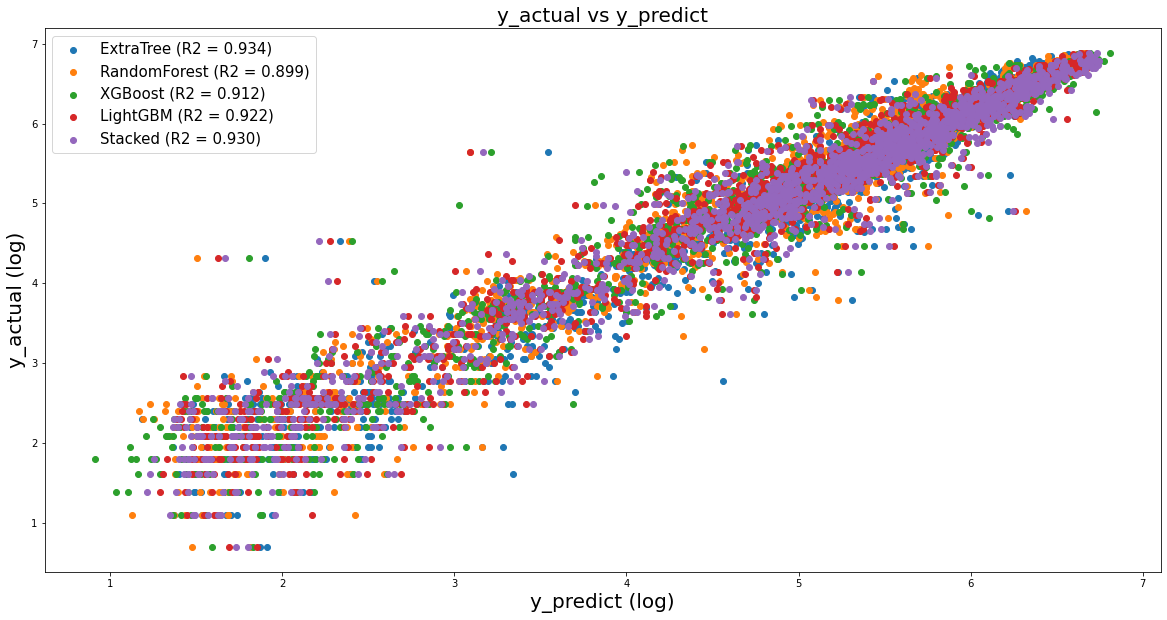

In [22]:
plt.scatter(plot_y_etr['y_pred_etr'], plot_y_etr['y_test'],label="ExtraTree (R2 = %0.3f)" % score_etr)
plt.scatter(plot_y_etr['y_pred_rfr'], plot_y_etr['y_test'],label="RandomForest (R2 = %0.3f)" % score_rfr)
plt.scatter(plot_y_etr['y_pred_xgbr'], plot_y_etr['y_test'],label="XGBoost (R2 = %0.3f)" % score_xgbr)
plt.scatter(plot_y_etr['y_pred_lgbm'], plot_y_etr['y_test'],label="LightGBM (R2 = %0.3f)" % score_lgbm)
plt.scatter(plot_y_etr['y_pred_stack'], plot_y_etr['y_test'],label="Stacked (R2 = %0.3f)" % score_stack)
plt.title('y_actual vs y_predict', fontsize=20)
plt.xlabel('y_predict (log)', fontsize=20)
plt.ylabel('y_actual (log)', fontsize=20)
plt.legend(fontsize=15)

# Package using pickle library

In [23]:
model.fit(df_final_X, df_final_y)


StackingRegressor(estimators=[('rfr',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(transformers=[('pipeline-1',
                                                                                 Pipeline(steps=[('onehotencoder',
                                                                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                                                                 ['holiday',
                                                                                  'workingday',
                                                                                  'season',
                                                                                  'month',
                                                                                  'day',
                                                                                 

- pickle.dump(model_xgb, open(filename, 'wb'))
- loaded_model = pickle.load(open(filename, 'rb'))

In [24]:
# pickle.dump(model, open('model_stack.sav', 'wb'))

In [25]:
loaded_model = pickle.load(open('model_stack.sav', 'rb'))

## Smaller pickle files (doesnt work)

In [27]:
# etr.fit(X_train, y_train)
# pickle.dump(model, open('model_etr.sav', 'wb'))

# rfr.fit(X_train, y_train)
# pickle.dump(model, open('model_rfr.sav', 'wb'))

# xgbr.fit(X_train, y_train)
# pickle.dump(model, open('model_xgbr.sav', 'wb'))

# lgbm.fit(X_train, y_train)
# pickle.dump(model, open('model_lgbm.sav', 'wb'))

# model.fit(X_train, y_train)


In [28]:
# level0 = list()

# loaded_model1 = pickle.load(open('model_etr.sav', 'rb'))
# loaded_model2 = pickle.load(open('model_rfr.sav', 'rb'))
# loaded_model3 = pickle.load(open('model_xgbr.sav', 'rb'))
# loaded_model4 = pickle.load(open('model_lgbm.sav', 'rb'))

# level0.append(('rfr', loaded_model1))
# level0.append(('etr', loaded_model2))
# level0.append(('lgbm', loaded_model3))
# level0.append(('xgbr', loaded_model4))

# # define meta learner model
# level1 = LinearRegression()
# # define the stacking ensemble
# model = StackingRegressor(estimators=level0, final_estimator=level1)
# # fit the model on all available data
# model.fit(X_train, y_train)
# score = model.score(X_test,y_test)
# score

## Experiment with different stacking combination (pair)
* 1a) rfr + etr
* 1b) rfr + lgbm
* 1c) rfr + xgbr
* 2a) etr + lgbm
* 2b) etr + xgbr
* 3a) lgbm + xgbr


In [9]:
# make a prediction with a stacking ensemble
from sklearn.ensemble import StackingRegressor

# define the base models
level0_1a = list()
level0_1b = list()
level0_1c = list()
level0_2a = list()
level0_2b = list()
level0_3a = list()

level0_1a.append(('rfr', make_pipeline(processor, RandomForestRegressor(random_state=1))))
level0_1a.append(('etr', make_pipeline(processor, ExtraTreesRegressor(random_state=1))))

level0_1b.append(('rfr', make_pipeline(processor, RandomForestRegressor(random_state=1))))
level0_1b.append(('lgbm', make_pipeline(processor, LGBMRegressor(random_state=1))))

level0_1c.append(('rfr', make_pipeline(processor, RandomForestRegressor(random_state=1))))
level0_1c.append(('xgbr', make_pipeline(processor, XGBRegressor(random_state=1))))

level0_2a.append(('etr', make_pipeline(processor, ExtraTreesRegressor(random_state=1))))
level0_2a.append(('lgbm', make_pipeline(processor, LGBMRegressor(random_state=1))))

level0_2b.append(('etr', make_pipeline(processor, ExtraTreesRegressor(random_state=1))))
level0_2b.append(('xgbr', make_pipeline(processor, XGBRegressor(random_state=1))))

level0_3a.append(('lgbm', make_pipeline(processor, LGBMRegressor(random_state=1))))
level0_3a.append(('xgbr', make_pipeline(processor, XGBRegressor(random_state=1))))

# define meta learner model
level1 = LinearRegression()

# define the stacking ensemble
model_1a = StackingRegressor(estimators=level0_1a, final_estimator=level1)
model_1b = StackingRegressor(estimators=level0_1b, final_estimator=level1)
model_1c = StackingRegressor(estimators=level0_1c, final_estimator=level1)
model_2a = StackingRegressor(estimators=level0_2a, final_estimator=level1)
model_2b = StackingRegressor(estimators=level0_2b, final_estimator=level1)
model_3a = StackingRegressor(estimators=level0_3a, final_estimator=level1)

# fit the model on all available data
model_1a.fit(X_train, y_train)
model_1b.fit(X_train, y_train)
model_1c.fit(X_train, y_train)
model_2a.fit(X_train, y_train)
model_2b.fit(X_train, y_train)
model_3a.fit(X_train, y_train)

# Get score for each models
score_1a = model_1a.score(X_test, y_test)
score_1b = model_1b.score(X_test, y_test)
score_1c = model_1c.score(X_test, y_test)
score_2a = model_2a.score(X_test, y_test)
score_2b = model_2b.score(X_test, y_test)
score_3a = model_3a.score(X_test, y_test)

# y_pred = model.predict(X_test)
# print('Predicted Value: %.3f' % (y_pred))

In [30]:
# print all scores
print('R2 score for 1a: %.3f' % (score_1a))
print('R2 score for 1b: %.3f' % (score_1b))
print('R2 score for 1c: %.3f' % (score_1c))
print('R2 score for 2a: %.3f' % (score_2a))
print('R2 score for 2b: %.3f' % (score_2b))
print('R2 score for 3a: %.3f' % (score_3a))

R2 score for 1a: 0.929
R2 score for 1b: 0.922
R2 score for 1c: 0.921
R2 score for 2a: 0.929
R2 score for 2b: 0.932
R2 score for 3a: 0.925


## Experiment with different stacking combination (3 in group)
* A) rfr + etr + lgbm
* B) rfr + etr + xgbr
* C) etr + lgbm + xgbr


In [31]:
# define the base models
level0_A = list()
level0_B = list()
level0_C = list()

level0_A.append(('rfr', make_pipeline(processor, RandomForestRegressor(random_state=1))))
level0_A.append(('etr', make_pipeline(processor, ExtraTreesRegressor(random_state=1))))
level0_A.append(('lgbm', make_pipeline(processor, LGBMRegressor(random_state=1))))

level0_B.append(('rfr', make_pipeline(processor, RandomForestRegressor(random_state=1))))
level0_B.append(('etr', make_pipeline(processor, ExtraTreesRegressor(random_state=1))))
level0_B.append(('xgbr', make_pipeline(processor, XGBRegressor(random_state=1))))

level0_C.append(('etr', make_pipeline(processor, ExtraTreesRegressor(random_state=1))))
level0_C.append(('lgbm', make_pipeline(processor, LGBMRegressor(random_state=1))))
level0_C.append(('xgbr', make_pipeline(processor, XGBRegressor(random_state=1))))


# define meta learner model
level1 = LinearRegression()

# define the stacking ensemble
model_A = StackingRegressor(estimators=level0_A, final_estimator=level1)
model_B = StackingRegressor(estimators=level0_B, final_estimator=level1)
model_C = StackingRegressor(estimators=level0_C, final_estimator=level1)


# fit the model on all available data
model_A.fit(X_train, y_train)
model_B.fit(X_train, y_train)
model_C.fit(X_train, y_train)


# Get score for each models
score_A = model_A.score(X_test, y_test)
score_B = model_B.score(X_test, y_test)
score_C = model_C.score(X_test, y_test)


# y_pred = model.predict(X_test)
# print('Predicted Value: %.3f' % (y_pred))

In [32]:
# print all scores
print('R2 score for A: %.3f' % (score_A))
print('R2 score for B: %.3f' % (score_B))
print('R2 score for C: %.3f' % (score_C))


R2 score for A: 0.930
R2 score for B: 0.931
R2 score for C: 0.929


## Y_actual vs Y_predict

In [33]:
y_pred_1a = model_1a.predict(X_test)
y_pred_1b = model_1b.predict(X_test)
y_pred_1c = model_1c.predict(X_test)
y_pred_2a = model_2a.predict(X_test)
y_pred_2b = model_2b.predict(X_test)
y_pred_3a = model_3a.predict(X_test)

In [34]:
plot_y_stack2 = pd.DataFrame(data=y_test, columns=['y_test'])

plot_y_stack2['y_test']=y_test
plot_y_stack2['y_pred_1a']=y_pred_1a
plot_y_stack2['y_pred_1b']=y_pred_1b
plot_y_stack2['y_pred_1c']=y_pred_1c
plot_y_stack2['y_pred_2a']=y_pred_2a
plot_y_stack2['y_pred_2b']=y_pred_2b
plot_y_stack2['y_pred_3a']=y_pred_3a
plot_y_stack2

,y_test,y_pred_1a,y_pred_1b,y_pred_1c,y_pred_2a,y_pred_2b,y_pred_3a
9063,5.129899,5.079803,4.940046,5.122320,4.980833,5.132250,4.976692
9064,4.382027,4.608912,4.774783,4.772575,4.730408,4.737733,4.765356
9065,4.248495,4.262262,4.270016,4.403656,4.265805,4.383842,4.288408
9066,3.583519,3.558961,3.445923,3.587847,3.468560,3.566555,3.472542
9067,2.564949,2.284379,2.515260,2.384231,2.436728,2.303210,2.479436
...,...,...,...,...,...,...,...
10881,5.820083,5.782828,5.783942,5.740601,5.795411,5.810872,5.775256
10882,5.488938,5.420676,5.470451,5.442117,5.464433,5.466453,5.463510
10883,5.129899,5.078126,5.062545,5.066797,5.073162,5.119121,5.060778
10884,4.867534,4.892133,4.808167,4.900586,4.838491,4.999119,4.817837


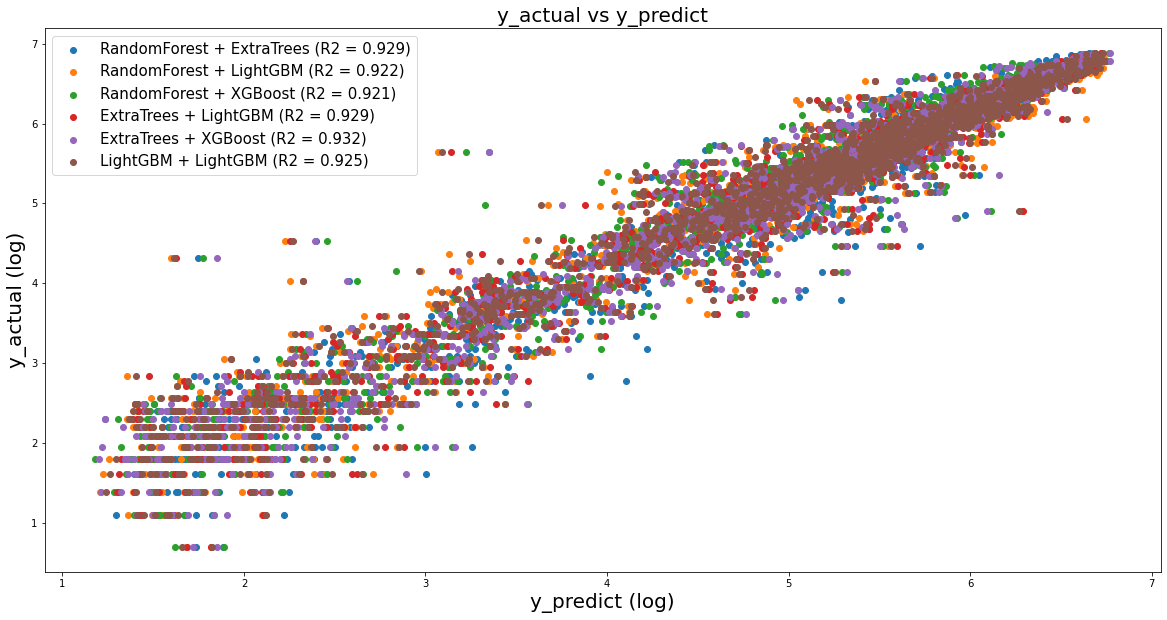

In [35]:
plt.scatter(plot_y_stack2['y_pred_1a'], plot_y_stack2['y_test'],label="RandomForest + ExtraTrees (R2 = %0.3f)" % score_1a)
plt.scatter(plot_y_stack2['y_pred_1b'], plot_y_stack2['y_test'],label="RandomForest + LightGBM (R2 = %0.3f)" % score_1b)
plt.scatter(plot_y_stack2['y_pred_1c'], plot_y_stack2['y_test'],label="RandomForest + XGBoost (R2 = %0.3f)" % score_1c)
plt.scatter(plot_y_stack2['y_pred_2a'], plot_y_stack2['y_test'],label="ExtraTrees + LightGBM (R2 = %0.3f)" % score_2a)
plt.scatter(plot_y_stack2['y_pred_2b'], plot_y_stack2['y_test'],label="ExtraTrees + XGBoost (R2 = %0.3f)" % score_2b)
plt.scatter(plot_y_stack2['y_pred_3a'], plot_y_stack2['y_test'],label="LightGBM + LightGBM (R2 = %0.3f)" % score_3a)
plt.title('y_actual vs y_predict', fontsize=20)
plt.xlabel('y_predict (log)', fontsize=20)
plt.ylabel('y_actual (log)', fontsize=20)
plt.legend(fontsize=15)

In [36]:
y_pred_A = model_A.predict(X_test)
y_pred_B = model_B.predict(X_test)
y_pred_C = model_C.predict(X_test)


plot_y_stack3 = pd.DataFrame(data=y_test, columns=['y_test'])

plot_y_stack3['y_test']=y_test
plot_y_stack3['y_pred_A']=y_pred_A
plot_y_stack3['y_pred_B']=y_pred_B
plot_y_stack3['y_pred_C']=y_pred_C

plot_y_stack3

,y_test,y_pred_A,y_pred_B,y_pred_C
9063,5.129899,4.960531,5.125158,4.988196
9064,4.382027,4.746926,4.728499,4.735290
9065,4.248495,4.262953,4.371910,4.274290
9066,3.583519,3.442805,3.567435,3.473113
9067,2.564949,2.448462,2.311005,2.433810
...,...,...,...,...
10881,5.820083,5.824896,5.797093,5.794653
10882,5.488938,5.482622,5.458260,5.465148
10883,5.129899,5.094517,5.105508,5.074330
10884,4.867534,4.872977,4.968260,4.844144


* A) rfr + etr + lgbm
* B) rfr + etr + xgbr
* C) etr + lgbm + xgbr

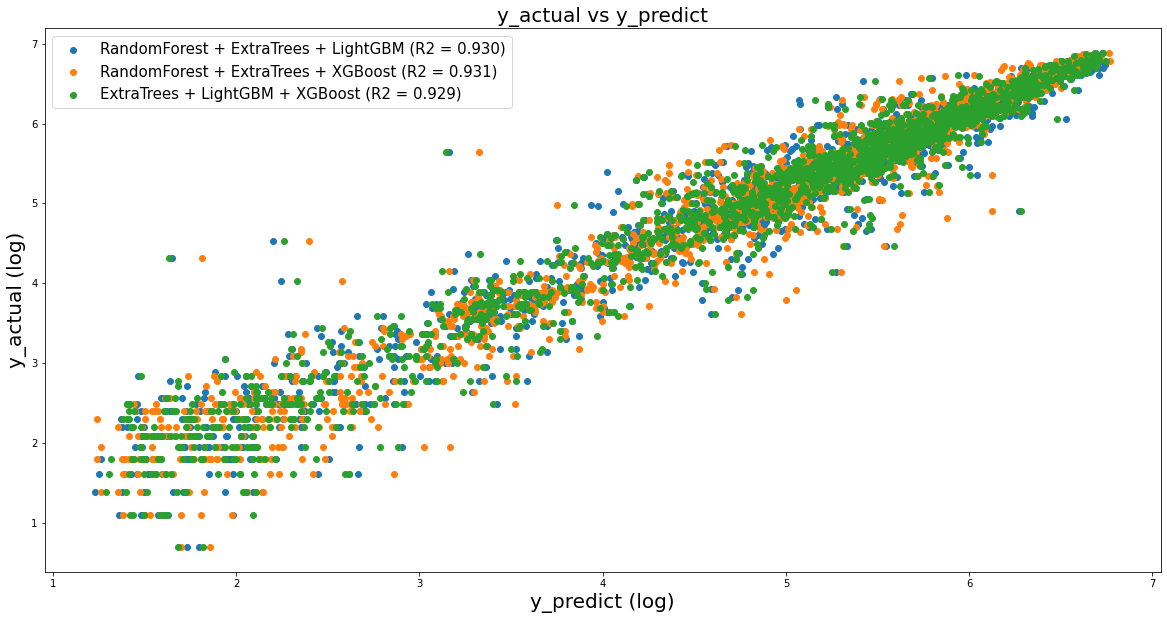

In [37]:
plt.scatter(plot_y_stack3['y_pred_A'], plot_y_stack3['y_test'],label="RandomForest + ExtraTrees + LightGBM (R2 = %0.3f)" % score_A)
plt.scatter(plot_y_stack3['y_pred_B'], plot_y_stack3['y_test'],label="RandomForest + ExtraTrees + XGBoost (R2 = %0.3f)" % score_B)
plt.scatter(plot_y_stack3['y_pred_C'], plot_y_stack3['y_test'],label="ExtraTrees + LightGBM + XGBoost (R2 = %0.3f)" % score_C)

plt.title('y_actual vs y_predict', fontsize=20)
plt.xlabel('y_predict (log)', fontsize=20)
plt.ylabel('y_actual (log)', fontsize=20)
plt.legend(fontsize=15)

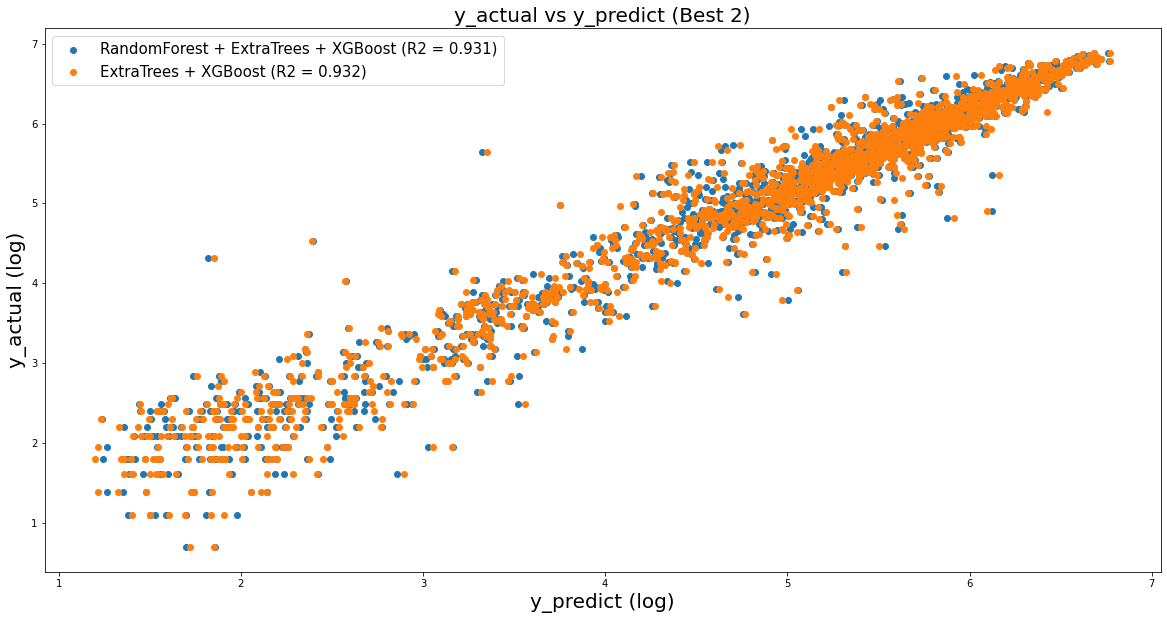

In [38]:
plt.scatter(plot_y_stack3['y_pred_B'], plot_y_stack3['y_test'],label="RandomForest + ExtraTrees + XGBoost (R2 = %0.3f)" % score_B)
plt.scatter(plot_y_stack2['y_pred_2b'], plot_y_stack2['y_test'],label="ExtraTrees + XGBoost (R2 = %0.3f)" % score_2b)

plt.title('y_actual vs y_predict (Best 2)', fontsize=20)
plt.xlabel('y_predict (log)', fontsize=20)
plt.ylabel('y_actual (log)', fontsize=20)
plt.legend(fontsize=15)

# Trying different level 1 stacking model gridsearch

https://www.analyticsvidhya.com/blog/2020/12/improve-predictive-model-score-stacking-regressor/

### RidgeCV

In [12]:
# define the base models
level0_1a = list()
level0_1b = list()
level0_1c = list()
level0_2a = list()
level0_2b = list()
level0_3a = list()

level0_1a.append(('rfr', make_pipeline(processor, RandomForestRegressor(random_state=1))))
level0_1a.append(('etr', make_pipeline(processor, ExtraTreesRegressor(random_state=1))))

level0_1b.append(('rfr', make_pipeline(processor, RandomForestRegressor(random_state=1))))
level0_1b.append(('lgbm', make_pipeline(processor, LGBMRegressor(random_state=1))))

level0_1c.append(('rfr', make_pipeline(processor, RandomForestRegressor(random_state=1))))
level0_1c.append(('xgbr', make_pipeline(processor, XGBRegressor(random_state=1))))

level0_2a.append(('etr', make_pipeline(processor, ExtraTreesRegressor(random_state=1))))
level0_2a.append(('lgbm', make_pipeline(processor, LGBMRegressor(random_state=1))))

level0_2b.append(('etr', make_pipeline(processor, ExtraTreesRegressor(random_state=1))))
level0_2b.append(('xgbr', make_pipeline(processor, XGBRegressor(random_state=1))))

level0_3a.append(('lgbm', make_pipeline(processor, LGBMRegressor(random_state=1))))
level0_3a.append(('xgbr', make_pipeline(processor, XGBRegressor(random_state=1))))

# define meta learner model Default = RidgeCV
# level1 = LinearRegression()

# define the stacking ensemble
model_1a_Ridge = StackingRegressor(estimators=level0_1a)
model_1b_Ridge = StackingRegressor(estimators=level0_1b)
model_1c_Ridge = StackingRegressor(estimators=level0_1c)
model_2a_Ridge = StackingRegressor(estimators=level0_2a)
model_2b_Ridge = StackingRegressor(estimators=level0_2b)
model_3a_Ridge = StackingRegressor(estimators=level0_3a)

# fit the model on all available data
model_1a_Ridge.fit(X_train, y_train)
model_1b_Ridge.fit(X_train, y_train)
model_1c_Ridge.fit(X_train, y_train)
model_2a_Ridge.fit(X_train, y_train)
model_2b_Ridge.fit(X_train, y_train)
model_3a_Ridge.fit(X_train, y_train)

# Get score for each models
score_1a_Ridge = model_1a_Ridge.score(X_test, y_test)
score_1b_Ridge = model_1b_Ridge.score(X_test, y_test)
score_1c_Ridge = model_1c_Ridge.score(X_test, y_test)
score_2a_Ridge = model_2a_Ridge.score(X_test, y_test)
score_2b_Ridge = model_2b_Ridge.score(X_test, y_test)
score_3a_Ridge = model_3a_Ridge.score(X_test, y_test)

In [40]:
# print all scores
print('R2 score for 1a (RidgeCV): %.3f' % (score_1a_Ridge))
print('R2 score for 1b (RidgeCV): %.3f' % (score_1b_Ridge))
print('R2 score for 1c (RidgeCV): %.3f' % (score_1c_Ridge))
print('R2 score for 2a (RidgeCV): %.3f' % (score_2a_Ridge))
print('R2 score for 2b (RidgeCV): %.3f' % (score_2b_Ridge))
print('R2 score for 3a (RidgeCV): %.3f' % (score_3a_Ridge))

R2 score for 1a (RidgeCV): 0.929
R2 score for 1b (RidgeCV): 0.922
R2 score for 1c (RidgeCV): 0.922
R2 score for 2a (RidgeCV): 0.929
R2 score for 2b (RidgeCV): 0.932
R2 score for 3a (RidgeCV): 0.925


### Linear SVR

In [13]:
from sklearn.svm import LinearSVR

# define meta learner model
level1 = LinearSVR()

# define the stacking ensemble
model_1a_LinearSVR = StackingRegressor(estimators=level0_1a, final_estimator=level1)
model_1b_LinearSVR = StackingRegressor(estimators=level0_1b, final_estimator=level1)
model_1c_LinearSVR = StackingRegressor(estimators=level0_1c, final_estimator=level1)
model_2a_LinearSVR = StackingRegressor(estimators=level0_2a, final_estimator=level1)
model_2b_LinearSVR = StackingRegressor(estimators=level0_2b, final_estimator=level1)
model_3a_LinearSVR = StackingRegressor(estimators=level0_3a, final_estimator=level1)

# fit the model on all available data
model_1a_LinearSVR.fit(X_train, y_train)
model_1b_LinearSVR.fit(X_train, y_train)
model_1c_LinearSVR.fit(X_train, y_train)
model_2a_LinearSVR.fit(X_train, y_train)
model_2b_LinearSVR.fit(X_train, y_train)
model_3a_LinearSVR.fit(X_train, y_train)

# Get score for each models
score_1a_LinearSVR = model_1a_LinearSVR.score(X_test, y_test)
score_1b_LinearSVR = model_1b_LinearSVR.score(X_test, y_test)
score_1c_LinearSVR = model_1c_LinearSVR.score(X_test, y_test)
score_2a_LinearSVR = model_2a_LinearSVR.score(X_test, y_test)
score_2b_LinearSVR = model_2b_LinearSVR.score(X_test, y_test)
score_3a_LinearSVR = model_3a_LinearSVR.score(X_test, y_test)

C:\Users\boure\anaconda3\envs\rb_ds\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\boure\anaconda3\envs\rb_ds\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\boure\anaconda3\envs\rb_ds\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\boure\anaconda3\envs\rb_ds\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\boure\anaconda3\envs\rb_ds\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\boure\anaconda3\envs\rb_ds\lib\site-packages\sklearn\svm\_base.py:1206: Conv

In [14]:
# print all scores
print('R2 score for 1a (LinearSVR): %.3f' % (score_1a_LinearSVR))
print('R2 score for 1b (LinearSVR): %.3f' % (score_1b_LinearSVR))
print('R2 score for 1c (LinearSVR): %.3f' % (score_1c_LinearSVR))
print('R2 score for 2a (LinearSVR): %.3f' % (score_2a_LinearSVR))
print('R2 score for 2b (LinearSVR): %.3f' % (score_2b_LinearSVR))
print('R2 score for 3a (LinearSVR): %.3f' % (score_3a_LinearSVR))

R2 score for 1a (LinearSVR): 0.943
R2 score for 1b (LinearSVR): 0.932
R2 score for 1c (LinearSVR): 0.937
R2 score for 2a (LinearSVR): 0.944
R2 score for 2b (LinearSVR): 0.940
R2 score for 3a (LinearSVR): 0.936


In [ ]:
filename = "model_stack.pkl"
pickle.dump(model_2a_LinearSVR, open(filename,'wb'))

### LassoCV

In [43]:
from sklearn.linear_model import LassoCV

# define meta learner model
level1 = LassoCV()

# define the stacking ensemble
model_1a_LassoCV = StackingRegressor(estimators=level0_1a, final_estimator=level1)
model_1b_LassoCV = StackingRegressor(estimators=level0_1b, final_estimator=level1)
model_1c_LassoCV = StackingRegressor(estimators=level0_1c, final_estimator=level1)
model_2a_LassoCV = StackingRegressor(estimators=level0_2a, final_estimator=level1)
model_2b_LassoCV = StackingRegressor(estimators=level0_2b, final_estimator=level1)
model_3a_LassoCV = StackingRegressor(estimators=level0_3a, final_estimator=level1)

# fit the model on all available data
model_1a_LassoCV.fit(X_train, y_train)
model_1b_LassoCV.fit(X_train, y_train)
model_1c_LassoCV.fit(X_train, y_train)
model_2a_LassoCV.fit(X_train, y_train)
model_2b_LassoCV.fit(X_train, y_train)
model_3a_LassoCV.fit(X_train, y_train)

# Get score for each models
score_1a_LassoCV = model_1a_LassoCV.score(X_test, y_test)
score_1b_LassoCV = model_1b_LassoCV.score(X_test, y_test)
score_1c_LassoCV = model_1c_LassoCV.score(X_test, y_test)
score_2a_LassoCV = model_2a_LassoCV.score(X_test, y_test)
score_2b_LassoCV = model_2b_LassoCV.score(X_test, y_test)
score_3a_LassoCV = model_3a_LassoCV.score(X_test, y_test)

In [44]:
# print all scores
print('R2 score for 1a (LassoCV): %.3f' % (score_1a_LassoCV))
print('R2 score for 1b (LassoCV): %.3f' % (score_1b_LassoCV))
print('R2 score for 1c (LassoCV): %.3f' % (score_1c_LassoCV))
print('R2 score for 2a (LassoCV): %.3f' % (score_2a_LassoCV))
print('R2 score for 2b (LassoCV): %.3f' % (score_2b_LassoCV))
print('R2 score for 3a (LassoCV): %.3f' % (score_3a_LassoCV))

R2 score for 1a (LassoCV): 0.928
R2 score for 1b (LassoCV): 0.924
R2 score for 1c (LassoCV): 0.921
R2 score for 2a (LassoCV): 0.929
R2 score for 2b (LassoCV): 0.931
R2 score for 3a (LassoCV): 0.925


### ElasticNet

In [45]:
from sklearn.linear_model import ElasticNetCV

# define meta learner model
level1 = ElasticNetCV()

# define the stacking ensemble
model_1a_ElasticNetCV = StackingRegressor(estimators=level0_1a, final_estimator=level1)
model_1b_ElasticNetCV = StackingRegressor(estimators=level0_1b, final_estimator=level1)
model_1c_ElasticNetCV = StackingRegressor(estimators=level0_1c, final_estimator=level1)
model_2a_ElasticNetCV = StackingRegressor(estimators=level0_2a, final_estimator=level1)
model_2b_ElasticNetCV = StackingRegressor(estimators=level0_2b, final_estimator=level1)
model_3a_ElasticNetCV = StackingRegressor(estimators=level0_3a, final_estimator=level1)

# fit the model on all available data
model_1a_ElasticNetCV.fit(X_train, y_train)
model_1b_ElasticNetCV.fit(X_train, y_train)
model_1c_ElasticNetCV.fit(X_train, y_train)
model_2a_ElasticNetCV.fit(X_train, y_train)
model_2b_ElasticNetCV.fit(X_train, y_train)
model_3a_ElasticNetCV.fit(X_train, y_train)

# Get score for each models
score_1a_ElasticNetCV = model_1a_ElasticNetCV.score(X_test, y_test)
score_1b_ElasticNetCV = model_1b_ElasticNetCV.score(X_test, y_test)
score_1c_ElasticNetCV = model_1c_ElasticNetCV.score(X_test, y_test)
score_2a_ElasticNetCV = model_2a_ElasticNetCV.score(X_test, y_test)
score_2b_ElasticNetCV = model_2b_ElasticNetCV.score(X_test, y_test)
score_3a_ElasticNetCV = model_3a_ElasticNetCV.score(X_test, y_test)

In [46]:
# print all scores
print('R2 score for 1a (ElasticNetCV): %.3f' % (score_1a_ElasticNetCV))
print('R2 score for 1b (ElasticNetCV): %.3f' % (score_1b_ElasticNetCV))
print('R2 score for 1c (ElasticNetCV): %.3f' % (score_1c_ElasticNetCV))
print('R2 score for 2a (ElasticNetCV): %.3f' % (score_2a_ElasticNetCV))
print('R2 score for 2b (ElasticNetCV): %.3f' % (score_2b_ElasticNetCV))
print('R2 score for 3a (ElasticNetCV): %.3f' % (score_3a_ElasticNetCV))

R2 score for 1a (ElasticNetCV): 0.926
R2 score for 1b (ElasticNetCV): 0.924
R2 score for 1c (ElasticNetCV): 0.921
R2 score for 2a (ElasticNetCV): 0.931
R2 score for 2b (ElasticNetCV): 0.932
R2 score for 3a (ElasticNetCV): 0.925


## RidgeCV for 3 algo

In [47]:

# define meta learner model Default = RidgeCV
# level1 = LinearRegression()

# define the stacking ensemble
model_A_Ridge = StackingRegressor(estimators=level0_A)
model_B_Ridge = StackingRegressor(estimators=level0_B)
model_C_Ridge = StackingRegressor(estimators=level0_C)

# fit the model on all available data
model_A_Ridge.fit(X_train, y_train)
model_B_Ridge.fit(X_train, y_train)
model_C_Ridge.fit(X_train, y_train)

# Get score for each models
score_A_Ridge = model_A_Ridge.score(X_test, y_test)
score_B_Ridge = model_B_Ridge.score(X_test, y_test)
score_C_Ridge = model_C_Ridge.score(X_test, y_test)


In [48]:
# print all scores
print('R2 score for A (RidgeCV): %.3f' % (score_A_Ridge))
print('R2 score for B (RidgeCV): %.3f' % (score_B_Ridge))
print('R2 score for C (RidgeCV): %.3f' % (score_C_Ridge))


R2 score for A (RidgeCV): 0.930
R2 score for B (RidgeCV): 0.931
R2 score for C (RidgeCV): 0.929


## LinearSVR for 3 algo

In [49]:
# define meta learner model
level1 = LinearSVR()

# define the stacking ensemble
model_A_LinearSVR = StackingRegressor(estimators=level0_A, final_estimator=level1)
model_B_LinearSVR = StackingRegressor(estimators=level0_B, final_estimator=level1)
model_C_LinearSVR = StackingRegressor(estimators=level0_C, final_estimator=level1)


# fit the model on all available data
model_A_LinearSVR.fit(X_train, y_train)
model_B_LinearSVR.fit(X_train, y_train)
model_C_LinearSVR.fit(X_train, y_train)

# Get score for each models
score_A_LinearSVR = model_A_LinearSVR.score(X_test, y_test)
score_B_LinearSVR = model_B_LinearSVR.score(X_test, y_test)
score_C_LinearSVR = model_C_LinearSVR.score(X_test, y_test)


C:\Users\Apprenant\anaconda3\envs\candiapp\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\Apprenant\anaconda3\envs\candiapp\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\Apprenant\anaconda3\envs\candiapp\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



In [50]:
# print all scores
print('R2 score for A (LinearSVR): %.3f' % (score_A_LinearSVR))
print('R2 score for B (LinearSVR): %.3f' % (score_B_LinearSVR))
print('R2 score for C (LinearSVR): %.3f' % (score_C_LinearSVR))

R2 score for A (LinearSVR): 0.941
R2 score for B (LinearSVR): 0.937
R2 score for C (LinearSVR): 0.947


## LassoCV for 3 algo

In [51]:
# define meta learner model
level1 = LassoCV()

# define the stacking ensemble
model_A_LassoCV = StackingRegressor(estimators=level0_1a, final_estimator=level1)
model_B_LassoCV = StackingRegressor(estimators=level0_1b, final_estimator=level1)
model_C_LassoCV = StackingRegressor(estimators=level0_1c, final_estimator=level1)


# fit the model on all available data
model_A_LassoCV.fit(X_train, y_train)
model_B_LassoCV.fit(X_train, y_train)
model_C_LassoCV.fit(X_train, y_train)


# Get score for each models
score_A_LassoCV = model_A_LassoCV.score(X_test, y_test)
score_B_LassoCV = model_B_LassoCV.score(X_test, y_test)
score_C_LassoCV = model_C_LassoCV.score(X_test, y_test)


In [52]:
# print all scores
print('R2 score for A (LassoCV): %.3f' % (score_A_LassoCV))
print('R2 score for B (LassoCV): %.3f' % (score_B_LassoCV))
print('R2 score for C (LassoCV): %.3f' % (score_C_LassoCV))

R2 score for A (LassoCV): 0.928
R2 score for B (LassoCV): 0.924
R2 score for C (LassoCV): 0.921


## ElasticNetCV for 3 algo

In [53]:
# define meta learner model
level1 = ElasticNetCV()

# define the stacking ensemble
model_A_ElasticNetCV = StackingRegressor(estimators=level0_1a, final_estimator=level1)
model_B_ElasticNetCV = StackingRegressor(estimators=level0_1b, final_estimator=level1)
model_C_ElasticNetCV = StackingRegressor(estimators=level0_1c, final_estimator=level1)


# fit the model on all available data
model_A_ElasticNetCV.fit(X_train, y_train)
model_B_ElasticNetCV.fit(X_train, y_train)
model_C_ElasticNetCV.fit(X_train, y_train)

# Get score for each models
score_A_ElasticNetCV = model_A_ElasticNetCV.score(X_test, y_test)
score_B_ElasticNetCV = model_B_ElasticNetCV.score(X_test, y_test)
score_C_ElasticNetCV = model_C_ElasticNetCV.score(X_test, y_test)


In [54]:
# print all scores
print('R2 score for A (ElasticNetCV): %.3f' % (score_A_ElasticNetCV))
print('R2 score for B (ElasticNetCV): %.3f' % (score_B_ElasticNetCV))
print('R2 score for C (ElasticNetCV): %.3f' % (score_C_ElasticNetCV))

R2 score for A (ElasticNetCV): 0.926
R2 score for B (ElasticNetCV): 0.924
R2 score for C (ElasticNetCV): 0.921


* 1a) rfr + etr
* 1b) rfr + lgbm
* 1c) rfr + xgbr
* 2a) etr + lgbm
* 2b) etr + xgbr
* 3a) lgbm + xgbr

* A) rfr + etr + lgbm
* B) rfr + etr + xgbr
* C) etr + lgbm + xgbr


## The best stacking model > 0.94 (without weather column)
* R2 score for C (LinearSVR): 0.947
* R2 score for 1a (LinearSVR): 0.943
* R2 score for 2a (LinearSVR): 0.943
* R2 score for 2b (LinearSVR): 0.946


In [ ]:
y_pred_C_LinearSVR = model_C_LinearSVR.predict(X_test)
y_pred_1a_LinearSVR = model_1a_LinearSVR.predict(X_test)
y_pred_2a_LinearSVR = model_2a_LinearSVR.predict(X_test)
y_pred_2b_LinearSVR = model_2b_LinearSVR.predict(X_test)


plot_best_stack = pd.DataFrame(data=y_test, columns=['y_test'])

plot_best_stack['y_test']=y_test
plot_best_stack['y_pred_C_LinearSVR']=y_pred_C_LinearSVR
plot_best_stack['y_pred_1a_LinearSVR']=y_pred_1a_LinearSVR
plot_best_stack['y_pred_2a_LinearSVR']=y_pred_2a_LinearSVR
plot_best_stack['y_pred_2b_LinearSVR']=y_pred_2b_LinearSVR

plot_best_stack

In [ ]:
plt.scatter(plot_best_stack['y_pred_C_LinearSVR'], plot_best_stack['y_test'],label="ExtraTrees + LightGBM + XGBoost (R2 = %0.3f)" % score_C_LinearSVR)
plt.scatter(plot_best_stack['y_pred_1a_LinearSVR'], plot_best_stack['y_test'],label="RandomForest + ExtraTrees (R2 = %0.3f)" % score_1a_LinearSVR)
plt.scatter(plot_best_stack['y_pred_2a_LinearSVR'], plot_best_stack['y_test'],label="ExtraTrees + LightGBM (R2 = %0.3f)" % score_2a_LinearSVR)
plt.scatter(plot_best_stack['y_pred_2b_LinearSVR'], plot_best_stack['y_test'],label="LightGBM + XGBoost (R2 = %0.3f)" % score_2b_LinearSVR)

plt.title('y_actual vs y_predict', fontsize=20)
plt.xlabel('y_predict (log)', fontsize=20)
plt.ylabel('y_actual (log)', fontsize=20)
plt.legend(fontsize=15)

* 1a) rfr + etr
* 1b) rfr + lgbm
* 1c) rfr + xgbr
* 2a) etr + lgbm
* 2b) etr + xgbr
* 3a) lgbm + xgbr

* A) rfr + etr + lgbm
* B) rfr + etr + xgbr
* C) etr + lgbm + xgbr